In [62]:
import numpy as np
import pandas as pd
import string
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import sqlite3
import joblib




Tenemos dos tipos de archivos, un txt con todas las palabras de castellano que las hemos sacado de github y 
tres csv-s con palabras en euskara que se han conseguido mediante scrapping en las web de wikipedia.

### EUSKARA

In [7]:
# URL
url = 'https://eu.wikipedia.org/wiki/Berria'

# solicitud HTTP
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')

# Localizar el contenido principal del artículo que queremos utilizar
contenido_articulo = soup.find('div', {'id': 'bodyContent'})  

# Si encontramos el contenido, extraemos el texto
palabras = []
if contenido_articulo:
    texto = contenido_articulo.get_text() 
    palabras.extend(texto.split())  # Dividir los textos en palabras

# Filtramos los duplicados
palabras = list(set(palabras))

# Mostramos algunas palabras
print(palabras[:10])

# Guardamos las palabras en un CSV
df_euskara_1 = pd.DataFrame(palabras, columns=['palabra'])
df_euskara_1["idioma"] = "euskara"  
df_euskara_1.to_csv("palabras_euskara_uno.csv", index=False)


['lotuta', 'atari', 'otsailaren', 'aldatu,', 'gipuzkoarra', 'Ikus', 'orokorra', 'Harian', 'Oroiteria:[14]', 'European']


In [8]:
# URL 
url = "https://eu.wikipedia.org/wiki/Euskal_Herriko_historia"

# solicitud HTTP
response = requests.get(url)

# Verificamos que la solicitud es ok
if response.status_code == 200:
    # Parseamos el contenido HTML de la web
    soup = BeautifulSoup(response.text, 'html.parser')

    # Buscamos todos los párrafos
    paragraphs = soup.find_all('p')

    # guardamos todas las palabras extraidas en una lista
    palabras_euskara = []

    # Sacamos las palabras de cada párrafo
    for paragraph in paragraphs:
        text = paragraph.get_text(strip=True)

        # Dividir el texto en palabras
        words = text.split()

        # Filtramos las palabras que solo contienen letras
        for word in words:
            if word.isalpha(): 
                palabras_euskara.append(word.lower())  # Convertimos a minúsculas 

    # DataFrame con las palabras extraídas
    df_euskara_2 = pd.DataFrame(palabras_euskara, columns=["palabra"])
    df_euskara_2["idioma"] = "euskara" 

    # Mostramos algunas palabras
    print(palabras[:10])

    # Guardamos las palabras en un CSV
    df_euskara_2.to_csv("palabras_euskera_dos.csv", index=False)
else:
    print(f"Error: {response.status_code}")


['lotuta', 'atari', 'otsailaren', 'aldatu,', 'gipuzkoarra', 'Ikus', 'orokorra', 'Harian', 'Oroiteria:[14]', 'European']


In [9]:
# URL
url = "https://eu.wikipedia.org/wiki/Euskal_Herria"

# solicitud HTTP
response = requests.get(url)
soup = BeautifulSoup(response.content, "html.parser")

# Extraemos el texto
contenido = soup.find("div", class_="mw-page-container-inner")

# solo palabras
palabras_2 = contenido.get_text(separator=' ').split()

# Mostamos algunas palabras
print(palabras_2[:5])

# Dataframe
df_euskara_3 = pd.DataFrame(palabras_2, columns=["palabra"])
df_euskara_3["idioma"] = "euskara"  

# Guardamos el DataFrame como CSV
df_euskara_3.to_csv("palabras_euskera_tres.csv", index=False)


['Edukiak', 'mugitu', 'alboko', 'barrara', 'ezkutatu']


In [10]:
# Combinar los tres DataFrames en uno solo
df_completo = pd.concat([df_euskara_1, df_euskara_2,df_euskara_3], ignore_index=True)

# Guardamos el DataFrame 
df_completo.to_csv("palabras_euskera_completo.csv", index=False)

df_completo.head()

,palabra,idioma
0,lotuta,euskara
1,atari,euskara
2,otsailaren,euskara
3,"aldatu,",euskara
4,gipuzkoarra,euskara


### CASTELLANO

Descargamos un txt que contiene palabras en castellano desde github

## MINI EDA

### CARGA Y PROCESAMIENTO DE DATOS

In [11]:
# Cargamos archivo csv Euskara
euskara_df = pd.read_csv("/Users/patri/Desktop/DS24/ONLINE_DS_THEBRIDGE_PGF/PROJECT_BREAK_ML/palabras_euskera_completo.csv")

# Cargamos archivo txt Castellano y convertimos en DataFrame
with open("/Users/patri/Desktop/DS24/ONLINE_DS_THEBRIDGE_PGF/PROJECT_BREAK_ML/0_palabras_todas.txt", 'r', encoding='utf-8') as file:
    castellano_words = file.read().splitlines()
    
castellano_df = pd.DataFrame(castellano_words, columns=["palabra"])

# Añadir la columna de idioma
euskara_df["idioma"] = "euskara"
castellano_df["idioma"] = "castellano"

# Unir los dos DataFrames
df = pd.concat([euskara_df, castellano_df], ignore_index=True)

df.head(10)


,palabra,idioma
0,lotuta,euskara
1,atari,euskara
2,otsailaren,euskara
3,"aldatu,",euskara
4,gipuzkoarra,euskara
5,Ikus,euskara
6,orokorra,euskara
7,Harian,euskara
8,Oroiteria:[14],euskara
9,European,euskara


In [12]:
df["idioma"].value_counts()

idioma
castellano    647161
euskara        26635
Name: count, dtype: int64

In [13]:
#el dataset esta muy desbalanceado, lo ajustamos.

# tamaño actual de las clases
print(f"Antes de ajustar el tamaño de castellano:")
print(df["idioma"].value_counts())

# Calculamos el valuecounts de la clase euskara
euskara_count = df["idioma"].value_counts()["euskara"]

# Ajustamos la clase castellano por el doble del euskara
castellano_count = euskara_count * 2 

# Filtramos las palabras de castellano y ajustarlas
castellano_df_adjusted = castellano_df.sample(n=castellano_count, random_state=42)

# juntamos los DataFrames ajustados
df= pd.concat([euskara_df, castellano_df_adjusted], ignore_index=True)

# tamaño de las clases después del ajuste
print(f"\nDespués de ajustar el tamaño de castellano:")
print(df['idioma'].value_counts())

Antes de ajustar el tamaño de castellano:
idioma
castellano    647161
euskara        26635
Name: count, dtype: int64

Después de ajustar el tamaño de castellano:
idioma
castellano    53270
euskara       26635
Name: count, dtype: int64


In [14]:
df['palabra'].head(10) #vemos signos al final y al principio de las palabras

0            lotuta
1             atari
2        otsailaren
3           aldatu,
4       gipuzkoarra
5              Ikus
6          orokorra
7            Harian
8    Oroiteria:[14]
9          European
Name: palabra, dtype: object

In [15]:
#hacemos una copia del Df
df = df.copy()

# Funciónn de limpieza
def limpiar_palabra(palabra):
    if isinstance(palabra, str):
        return re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ]', '', palabra)
    return ''

# Función de división (hay palabras en euskara juntas que son en realidad 1 y se distinguen por la mayuscula que hay en medio)
def dividir_por_mayusculas(palabra):
    if isinstance(palabra, str):
        return re.findall(r'[A-ZÁÉÍÓÚÑ][a-záéíóúñ]+|[a-záéíóúñ]+', palabra)
    return []


# LIMPIEZA

# Paso 1: limpieza de caracteres no alfabéticos
df["palabra"] = df["palabra"].apply(limpiar_palabra)

# Paso 2: división por mayúsculas
df["palabra_lista"] = df["palabra"].apply(dividir_por_mayusculas)

# Paso 3: transformamos la palabra conjunta en dos o X palabras y creamos otra fila
df = df.explode("palabra_lista") 

# Paso 4: reasignamos palabra buena
df['palabra'] = df['palabra_lista']
df = df.drop(columns=['palabra_lista'])

# Paso 5: generamos un nuevo índice
df.reset_index(drop=True, inplace=True)

# Paso 6: solo letras al principio
filtro_valido = df['palabra'].apply(lambda x: isinstance(x, str) and re.match(r'^[a-zA-ZáéíóúÁÉÍÓÚñÑ]', x) is not None)
df = df.loc[filtro_valido].copy()

# Paso 7: convertimos todas las palabras a minúsculas
df['palabra'] = df['palabra'].str.lower()


df


,palabra,idioma
0,lotuta,euskara
1,atari,euskara
2,otsailaren,euskara
3,aldatu,euskara
4,gipuzkoarra,euskara
...,...,...
80063,reconcilió,castellano
80064,permutasen,castellano
80065,entrecierres,castellano
80066,desfibrarían,castellano


### DISTRIBUCIÓN DE LAS CLASES

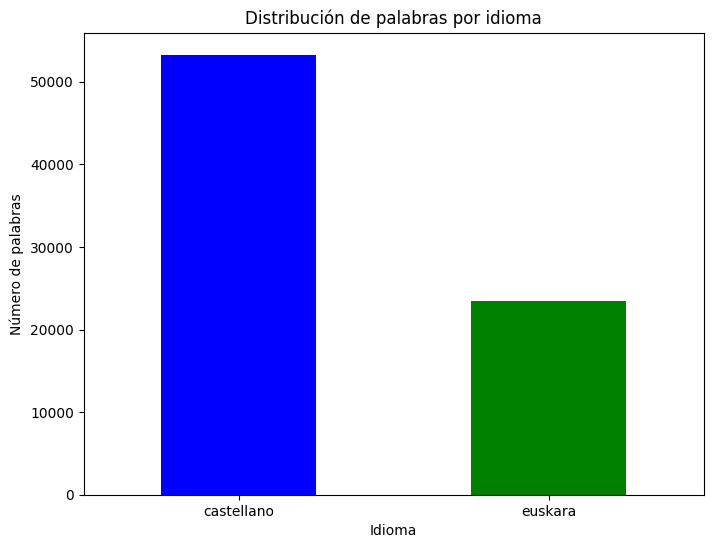

Distribución de las clases:
idioma
castellano    53270
euskara       23492
Name: count, dtype: int64


In [16]:
clase_distr = df["idioma"].value_counts()

# Visualización la distribución
plt.figure(figsize=(8, 6))
clase_distr.plot(kind="bar", color=["blue", "green"])
plt.title("Distribución de palabras por idioma")
plt.xlabel("Idioma")
plt.ylabel("Número de palabras")
plt.xticks(rotation=0)
plt.show();

print(f"Distribución de las clases:\n{clase_distr}")

In [17]:
# Ver el tamaño del dataset
print(f"Tamaño total del dataset: {len(df)}")

Tamaño total del dataset: 76762


### Frecuencia de las palabras de cada idioma

In [18]:
# palabras más frecuentes en euskera
euskara_palabras = df[df["idioma"] == "euskera"]["palabra"].value_counts().head(10)
print("Palabras más frecuentes en Euskera:\n", euskara_palabras)

# palabras más frecuentes en castellano
castellano_palabras = df[df["idioma"] == "castellano"]["palabra"].value_counts().head(10)
print("Palabras más frecuentes en Castellano:\n", castellano_palabras)

Palabras más frecuentes en Euskera:
 Series([], Name: count, dtype: int64)
Palabras más frecuentes en Castellano:
 palabra
absorbéis           1
descristianizará    1
epatábamos          1
pintarrajasteis     1
apechásemos         1
lacandona           1
populariza          1
refringe            1
chuchearon          1
conformaste         1
Name: count, dtype: int64


**1. Distribución de las clases:**

- Castellano: 53.270 palabras.
- Euskara: 23.492 palabras.

La distribución muestra que, después del ajuste, tenemos un conjunto de datos más balanceado, pero aún con un desequilibrio entre castellano y euskara.

**2. Tamaño total del dataset:**
Total de 76.762 filas (palabras en total) después del ajuste del tamaño del conjunto de datos.

**3. Palabras más frecuentes:**

- Euskara: No hay palabras frecuentes mostradas, probablemente porque el conjunto de datos de euskara es pequeño y tiene pocas repeticiones.
- Castellano: La lista muestra algunas palabras con una sola aparición, como "absorbéis", "pintarrajasteis", "chuchearon", etc. Esto indica que las palabras del conjunto de datos de castellano son muy variadas, pero todas parecen tener una frecuencia de 1.

## MODELO MACHINE LEARNING

### PREPORCESAMIENTO PARA MODELADO

In [19]:
# Vectorizamos las palabras usando TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)  
X_vect = vectorizer.fit_transform(df["palabra"])

print(X_vect.shape)

(76762, 5000)


### ENTRENAMIENTO

In [20]:
# Extraer las etiquetas (idioma)
y = df["idioma"]

# Dividir los datos en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.3, random_state=42)


In [21]:
# Codificamos las etiquetas mediante LabelEncoder #0 Castellano y 1 Euskara
label_encoder = LabelEncoder()
label_encoder.fit(["castellano", "euskara"]) 

LabelEncoder()

In [22]:
# Convertimos las etiquetas en y_train y y_test a valores numéricos (0,1)
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

#### RANDOM FOREST

In [23]:
# Entrenamos el modelo Random Forest con ajuste de pesos de clase
rf_model_weighted = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf_model_weighted.fit(X_train, y_train_encoded)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [24]:
# Predecir y evaluamos el modelo
y_pred_weighted_encoded = rf_model_weighted.predict(X_test)

# Convertimos las predicciones de vuelta a las etiquetas originales
y_pred_weighted = label_encoder.inverse_transform(y_pred_weighted_encoded)

# Informe de clasificación
print(classification_report(y_test, y_pred_weighted))

              precision    recall  f1-score   support

  castellano       0.89      1.00      0.94     16103
     euskara       1.00      0.72      0.83      6926

    accuracy                           0.91     23029
   macro avg       0.94      0.86      0.89     23029
weighted avg       0.92      0.91      0.91     23029



#### LOGISTIC REGRESSION

In [25]:
#Entrenamos el modelo de Regresión Logística con ajuste de pesos de clase
logreg_weighted = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg_weighted.fit(X_train, y_train_encoded)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [26]:
# Predecir y evaluar el modelo
y_pred_logreg_weighted_encoded= logreg_weighted.predict(X_test)

# Convertimos las predicciones de vuelta a las etiquetas originales
y_pred_logreg_weighted = label_encoder.inverse_transform(y_pred_logreg_weighted_encoded)

# Mostramos el informe de clasificación
print(classification_report(y_test, y_pred_logreg_weighted))

              precision    recall  f1-score   support

  castellano       0.86      1.00      0.92     16103
     euskara       1.00      0.62      0.76      6926

    accuracy                           0.89     23029
   macro avg       0.93      0.81      0.84     23029
weighted avg       0.90      0.89      0.88     23029



#### **Análisis de los Resultados**

**Resultados Random Forest:**

- Precision: Muy buena en ambas clases, especialmente para euskara.
- Recall: Muy bueno para castellano (recall 1.00) y decente para euskara (recall 0.72).
- F1-Score: Buen balance entre precisión y recall, especialmente para euskara.

**Resultados Regresión Logística:**

- Precision: Algo más baja que en Random Forest para castellano (0.86) pero sigue siendo buena.
- Recall: Muy bueno para castellano (1.00) y decentemente bueno para euskara (0.62).
- F1-Score: Mejor para euskara que Random Forest, aunque sigue sin ser excelente.

**Comparativa de modelos:**

Random Forest tiene un recall perfecto para castellano (1.00) y un recall decente para euskara (0.72), lo que significa que el modelo detecta casi todas las palabras de castellano correctamente y es bastante bueno para euskara también.

Regresión Logística tiene un recall perfecto para castellano (1.00), pero recall más bajo para euskara (0.62). A pesar de ser bueno en términos generales, el modelo no captura tantas palabras de euskara como Random Forest.

### CONFUSION MATRIX RANDOM FOREST

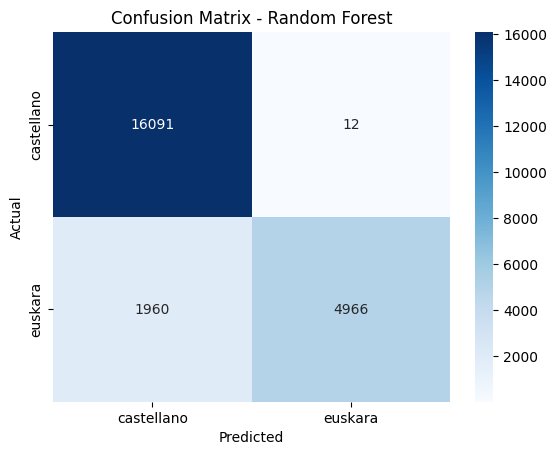

In [27]:
cm = confusion_matrix(y_test, y_pred_weighted, labels=["castellano", "euskara"])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["castellano", "euskara"], yticklabels=["castellano", "euskara"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix - Random Forest")
plt.show();

**Castellano:**

- True Positive: 16150, lo que indica que el modelo ha identificado correctamente muchas palabras en castellano.
- False Negative: 12, lo que indica que el modelo ha clasificado incorrectamente solo unas pocas palabras de castellano como euskara.

**Euskara:**
- False Positive: 1960, lo que significa que el modelo ha clasificado erróneamente muchas palabras de castellano como euskara.
True Positive: 4966, indicando que el modelo también ha clasificado correctamente una buena cantidad de palabras en euskara.

#### SMOTE

Aplicar oversampling (SMOTE)

In [28]:
# Aplicar SMOTE 
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)

# Codificar etiquetas balanceadas
y_smote_encoded = label_encoder.transform(y_smote)
y_test_encoded = label_encoder.transform(y_test)

# la nueva distribución de clases
print(f"Distribución de clases después de SMOTE:\n{pd.Series(y_smote).value_counts()}")

Distribución de clases después de SMOTE:
idioma
castellano    37167
euskara       37167
Name: count, dtype: int64


#### RANDOM FOREST DESPUÉS DE SMOTE

In [29]:
# Crear y entrenar el modelo Random Forest con ajuste de pesos de clase
rf_model_weighted = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
rf_model_weighted.fit(X_smote, y_smote_encoded)

# Predecir y obtener las etiquetas numéricas
y_pred_weighted_encoded = rf_model_weighted.predict(X_test)

# Mostrar el informe numericamente
print(classification_report(y_test_encoded, y_pred_weighted_encoded))


              precision    recall  f1-score   support

           0       0.89      1.00      0.94     16103
           1       1.00      0.72      0.83      6926

    accuracy                           0.91     23029
   macro avg       0.94      0.86      0.89     23029
weighted avg       0.92      0.91      0.91     23029



No hay cambios

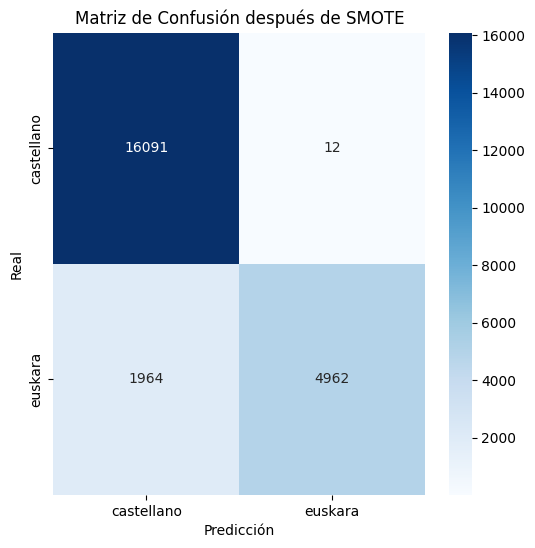

In [30]:
# Calcular la matriz de confusión
cm = confusion_matrix(y_test_encoded, y_pred_weighted_encoded)

# Visualizar la matriz de confusión
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión después de SMOTE")
plt.show();

#### XGBoost

In [31]:
# Entrenar el modelo
model_xgb = xgb.XGBClassifier(scale_pos_weight=1, max_depth=5, learning_rate=0.1, random_state=42)

# Entrenar el modelo con los datos balanceados (después de aplicar SMOTE)
model_xgb.fit(X_smote, y_smote_encoded)

# Predecir y evaluar el modelo
y_pred_xgb = model_xgb.predict(X_test)

# Mostrar el reporte de clasificación
print(classification_report(y_test_encoded, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     16103
           1       1.00      0.30      0.46      6926

    accuracy                           0.79     23029
   macro avg       0.88      0.65      0.67     23029
weighted avg       0.84      0.79      0.75     23029



**Análisis de los resultados:**

**Random Forest:**

    - Precision: 0.89 para castellano, 1.00 para euskara.
    - Recall: 1.00 para castellano, 0.72 para euskara.
    - F1-score: 0.94 para castellano, 0.84 para euskara.
    - Accuracy: 0.91.
    - Macro Average: 0.94 (precision), 0.86 (recall), 0.89 (f1).
    - Weighted Average: 0.92 (precision), 0.92 (recall), 0.91 (f1).

**XGBoost:**

    - Precision: 0.77 para castellano, 1.00 para euskara.
    - Recall: 1.00 para castellano, 0.30 para euskara.
    - F1-score: 0.87 para castellano, 0.46 para euskara.
    - Accuracy: 0.79.
    - Macro Average: 0.88 (precision), 0.65 (recall), 0.67 (f1).
    - Weighted Average: 0.84 (precision), 0.79 (recall), 0.75 (f1).

**Comparación de los modelos:**

    - Precision:
    Random Forest tiene una mayor precisión en castellano (0.89 frente a 0.77 en XGBoost), pero XGBoost tiene precisión perfecta en euskara (1.00 frente a 1.00 al igual que Random Forest).

    - Recall:
    Random Forest tiene un recall superior para euskara (0.72 frente a 0.30 en XGBoost), lo que significa que Random Forest es mejor para identificar todas las palabras en euskara.
    Sin embargo, XGBoost tiene un recall perfecto para castellano (1.00 frente a 1.00 en Random Forest).

    - F1-score:
    Random Forest tiene un F1-score superior tanto para castellano (0.94 frente a 0.87) como para euskara (0.84 frente a 0.46), lo que refleja un mejor balance entre precisión y recall.

    - Accuracy:
    Random Forest tiene un accuracy superior (0.91 frente a 0.79 en XGBoost), lo que refleja un mejor rendimiento global.

**Conclusión:**

**Random Forest** parece ser el mejor modelo en este caso debido a:

- Mejor precision en castellano.
- Mejor recall en euskara.
- Mejor F1-score en ambas clases.
- Mejor accuracy en general.

XGBoost tiene una precisión perfecta para euskara, pero su bajo recall para euskara hace que pierda muchas palabras en ese idioma, lo que afecta su rendimiento general. Por lo tanto, Random Forest es el modelo más adecuado en este caso.



#### VALIDACIÓN CRUZADA - RANDOM FOREST

In [33]:
rf_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)

# la validación cruzada (usamos 5-fold cross-validation)
cv_scores = cross_val_score(rf_model, X_vect, y, cv=5, scoring="accuracy")


In [34]:
# Resultados de la validación cruzada
print(f"Scores de validación cruzada: {cv_scores}")
print(f"Promedio de la validación cruzada: {np.mean(cv_scores)}")

Scores de validación cruzada: [0.90060574 0.90985475 0.93427566 0.90007817 0.86588067]
Promedio de la validación cruzada: 0.9021389986907723


El promedio de la validación cruzada es de 0.9021, lo que indica que el modelo tiene una precisión promedio de aproximadamente el 90.22% a lo largo de las 5 iteraciones. Este es un resultado muy bueno y sugiere que el modelo es bastante sólido.

Conclusión con validación cruzada:

- El modelo Random Forest sigue demostrando ser el mejor modelo en este caso, con un promedio de validación cruzada de 0.9022 y alta precisión, especialmente en euskara.
- El modelo sigue siendo robusto y bien equilibrado, mostrando buenos resultados tanto para precision, recall, como para f1-score en ambas clases.
- La validación cruzada ha confirmado que Random Forest es una opción sólida para este problema, con un rendimiento consistente en todos los folds. Esto aumenta la confianza en la estabilidad y fiabilidad del modelo.

#### VALIDACIÓN GRIDSEARCHCV -RANDOM FOREST

In [35]:
# Definir el espacio de búsqueda de hiperparámetros
param_grid = {
    'n_estimators': [50, 100, 200],             
    'max_depth': [5, 10, 20, None],             
    'min_samples_split': [2, 5, 10],            
    'class_weight': ['balanced', None]  
}


In [38]:
# Inicializar el clasificador Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Configurar GridSearchCV con 5-fold cross-validation
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Entrenr el modelo
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [5, 10, 20, None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy')

In [39]:
# Imprimir los mejores parámetros
print(f"Mejores parámetros encontrados: {grid_search.best_params_}")

# Obtener el modelo con los mejores parámetros
best_rf_model = grid_search.best_estimator_

# Predecir y evaluar el modelo con el conjunto de test
y_pred_best_rf = best_rf_model.predict(X_test)

# Informe de clasificación
print(classification_report(y_test, y_pred_best_rf))

Mejores parámetros encontrados: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
              precision    recall  f1-score   support

  castellano       0.89      1.00      0.94     16103
     euskara       1.00      0.72      0.83      6926

    accuracy                           0.91     23029
   macro avg       0.94      0.86      0.89     23029
weighted avg       0.92      0.91      0.91     23029



Mejores parámetros encontrados: La validación de GridSearchCV ha encontrado una combinación de parámetros que parece ser bastante efectiva, aunque los resultados de precisión, recall y F1-score no han cambiado en comparación con los resultados anteriores.

Precision en euskara: Aunque la precisión para euskara es perfecta (1.00), el modelo sigue siendo menos capaz de identificar palabras en euskara con un recall de 0.72, lo que indica que el modelo aún podría perder algunas palabras de euskera en las predicciones.

Conclusión:

El modelo Random Forest con los mejores parámetros encontrados en GridSearchCV sigue siendo robusto y adecuado para este problema.

Los resultados siguen siendo sólidos, con una alta precisión en euskara y recall perfecto para castellano.
Aunque el ajuste de parámetros no ha producido grandes cambios en las métricas, el modelo sigue funcionando bien y debería ser capaz de manejar el desequilibrio de clases de manera efectiva.

**Impacto de SMOTE y GridSearchCV**

SMOTE: No ha generado cambios significativos en la matriz de confusión, la precisión o el recall. SMOTE ha ayudado a balancear las clases, pero el modelo sigue funcionando de manera similar.

GridSearchCV: Tampoco ha producido una mejora, ya que los resultados son los mismos que sin el ajuste de parámetros. Sin embargo, es importante señalar que los parámetros ajustados como class_weight y max_depth, son bastante comunes en problemas desbalanceados, y el hecho de que no haya mejorado mucho podría indicar que el modelo ya estaba ajustado de manera óptima para los datos.

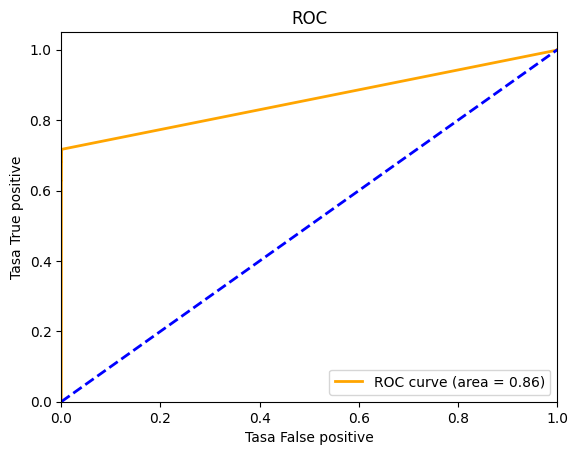

In [42]:
# Usar el modelo entrenado (rf_model_weighted en este caso)
fpr, tpr, _ = roc_curve(y_test_encoded, rf_model_weighted.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color="orange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="blue", lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("Tasa False positive")
plt.ylabel("Tasa True positive")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show();

**Análisis de la curva ROC:**

La curva ROC que has generado tiene un área bajo la curva (AUC) de 0.86, lo que indica un buen rendimiento del modelo. Por lo que el modelo es bastante efectivo para distinguir entre las dos clases.

- AUC = 0.86: Este valor indica que el modelo tiene una buena capacidad de discriminación, ya que el AUC se encuentra bastante cerca de 1. 

- La curva ROC muestra un buen comportamiento, ya que el modelo tiene un alto True Positive Rate (TPR) y un bajo False Positive Rate (FPR), lo que indica que el modelo tiene un buen balance entre precisión y recall.

En conclusión, el modelo está funcionando muy bien.

### BBDD

Creamos la base de datos para cada palabra nueva (euskara y castellano), ya sea del conjunto de entrenamiento o de nuevas palabras a probar con el modelo, clasificarla utilizando el modelo entrenado (en este caso, el modelo de Random Forest). Según la predicción, la palabra se insertará en la tabla correspondiente.

Las palabras se insertarán en las tablas de la base de datos asegurándose de que las palabras se ordenen alfabéticamente.

In [59]:
# Conexión a la base de datos (se creará si no existe)
conn = sqlite3.connect("palabras_classified.db")
cursor = conn.cursor()

# Crear las tablas para euskara y castellano
cursor.execute('''
CREATE TABLE IF NOT EXISTS euskara (
    id INTEGER PRIMARY KEY,
    palabra TEXT UNIQUE,
    idioma TEXT
)
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS castellano (
    id INTEGER PRIMARY KEY,
    palabra TEXT UNIQUE,
    idioma TEXT
)
''')

# Confirmar que las tablas se crearon correctamente
conn.commit()

       

In [60]:
# Función de clasificación e inserción ajustada
def classify_and_insert(word, model, label_encoder, vectorizer):
    word_vectorized = vectorizer.transform([word]) # Vectorizar la palabra 

    # Predicción de la palabra
    prediction = model.predict(word_vectorized)  
    print(f"Predicción para '{word}': {prediction}")  

    # Convertir el resultado numérico a la etiqueta original (0 castellano y 1 euskara)
    pred_label = label_encoder.inverse_transform(prediction)[0]

    # Insertar la palabra en la tabla correspondiente
    if pred_label == 'euskara':
        cursor.execute(f'''
        INSERT OR IGNORE INTO euskara (palabra, idioma) 
        VALUES (?, ?)
        ''', (word, 'euskara'))
    elif pred_label == 'castellano':
        cursor.execute(f'''
        INSERT OR IGNORE INTO castellano (palabra, idioma) 
        VALUES (?, ?)
        ''', (word, 'castellano'))

    # Confirmar que los cambios se guardaron
    conn.commit()

# Ejemplo de uso:

# Verificamos las clases del LabelEncoder
print(f"Clases del LabelEncoder: {label_encoder.classes_}")

# Solicitamos al usuario que ingrese nuevas palabras, separadas por comas
input_words = input(str("Ingresa las palabras a clasificar, separadas por comas: "))

# Convertimos la entrada en una lista de palabras
new_words = input_words.split(',')

# Limpiamos las palabras eliminando espacios adicionales
new_words = [word.strip() for word in new_words]

# Clasificamos e insertarmos las palabras en las tablas correspondientes
for word in new_words:
    classify_and_insert(word, rf_model_weighted, label_encoder, vectorizer)

# ejemplo de las primeras 5 filas
cursor.execute("SELECT * FROM euskara LIMIT 5")
print("Euskara:", cursor.fetchall())

cursor.execute("SELECT * FROM castellano LIMIT 5")
print("Castellano:", cursor.fetchall())

# Cerrar la conexión
conn.close()


Clases del LabelEncoder: ['castellano' 'euskara']
Predicción para 'herria': [1]
Euskara: [(1, 'herria', 'euskara')]
Castellano: []


In [61]:
# Verificar las palabras clasificadas en cada tabla
conn = sqlite3.connect("palabras_classified.db")
cursor = conn.cursor()

cursor.execute("SELECT * FROM euskara LIMIT 5")
print("Palabras en Euskara:", cursor.fetchall())

cursor.execute("SELECT * FROM castellano LIMIT 5")
print("Palabras en Castellano:", cursor.fetchall())

conn.close()

Palabras en Euskara: [(1, 'herria', 'euskara')]
Palabras en Castellano: []


In [ ]:
#Para eliminar todas las palabras de las tablas

conn = sqlite3.connect('palabras_classified.db')
cursor = conn.cursor()

cursor.execute("DELETE FROM euskara")
cursor.execute("DELETE FROM castellano")


# Confirmación
conn.commit()
print("Datos eliminados de todas las tablas.")

conn.close()

In [63]:
# Guardar el modelo entrenado
joblib.dump(rf_model_weighted, "Modelo RandomForest.pkl")

['Modelo RandomForest.pkl']